In [3]:
!pip install statsmodels==0.12.2 -q

     |████████████████████████████████| 9.5MB 4.0MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.base.transform import BoxCox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

In [5]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)
aus_retail.head()

,A3349335T,A3349627V,A3349338X,A3349398A,A3349468W,A3349336V,A3349337W,A3349397X,A3349399C,A3349874C,A3349871W,A3349790V,A3349556W,A3349791W,A3349401C,A3349873A,A3349872X,A3349709X,A3349792X,A3349789K,A3349555V,A3349565X,A3349414R,A3349799R,A3349642T,A3349413L,A3349564W,A3349416V,A3349643V,A3349483V,A3349722T,A3349727C,A3349641R,A3349639C,A3349415T,A3349349F,A3349563V,A3349350R,A3349640L,A3349566A,...,A3349605F,A3349688X,A3349456L,A3349774V,A3349848X,A3349457R,A3349851L,A3349604C,A3349608L,A3349609R,A3349773T,A3349852R,A3349775W,A3349776X,A3349607K,A3349849A,A3349850K,A3349606J,A3349932R,A3349862V,A3349462J,A3349463K,A3349334R,A3349863W,A3349781T,A3349861T,A3349626T,A3349617R,A3349546T,A3349787F,A3349333L,A3349860R,A3349464L,A3349389X,A3349461F,A3349788J,A3349547V,A3349388W,A3349870V,A3349396W
Series ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-04-01,303.1,41.7,63.9,408.7,65.8,91.8,53.6,211.3,94.0,32.7,126.7,178.3,50.4,22.2,43.0,62.4,178.0,61.8,85.4,147.2,1250.2,257.9,17.3,34.9,310.2,58.2,55.8,59.1,173.1,93.6,26.3,119.9,104.2,42.2,15.6,31.6,34.4,123.7,36.4,48.7,...,1.6,15.5,2.7,4.4,2.6,9.7,3.7,2.2,5.9,10.3,2.3,1.1,2.5,2.2,8.1,4.4,3.2,7.6,57.1,933.4,79.6,149.6,1162.6,200.3,243.4,148.6,592.3,268.5,91.4,359.9,460.1,135.1,64.9,125.6,153.5,479.1,146.3,196.1,342.4,3396.4
1982-05-01,297.8,43.1,64.0,404.9,65.8,102.6,55.4,223.8,105.7,35.6,141.3,202.8,49.9,23.1,45.3,63.1,181.5,60.8,84.8,145.6,1300.0,257.4,18.1,34.6,310.1,62.0,58.4,59.2,179.5,95.3,27.1,122.5,110.2,42.1,15.8,31.5,34.4,123.9,36.2,48.9,...,1.6,15.1,3.0,4.9,3.3,11.1,3.8,2.1,5.9,10.6,2.5,1.0,2.5,2.0,8.0,3.4,3.3,6.7,57.3,920.5,80.8,149.7,1150.9,210.3,268.3,151.0,629.6,289.8,96.8,386.6,502.6,134.9,67.7,128.7,154.8,486.1,145.5,196.6,342.1,3497.9
1982-06-01,298.0,40.3,62.7,401.0,62.3,105.0,48.4,215.7,95.1,32.5,127.6,176.3,48.0,22.8,43.7,59.6,174.1,58.7,80.7,139.4,1234.2,261.2,18.1,34.6,313.9,53.8,53.7,59.8,167.3,85.2,24.3,109.6,96.7,38.5,15.2,29.6,33.5,116.8,35.7,47.1,...,1.7,15.5,2.5,4.8,2.7,9.9,3.2,2.0,5.1,9.9,2.3,1.0,2.5,2.0,7.8,3.6,3.5,7.1,55.3,933.6,77.3,149.0,1160.0,198.7,266.1,142.6,607.4,261.9,88.6,350.5,443.8,128.2,65.5,125.0,148.8,467.5,140.2,188.5,328.7,3357.8
1982-07-01,307.9,40.9,65.6,414.4,68.2,106.0,52.1,226.3,95.3,33.5,128.8,172.6,48.6,23.2,46.5,61.9,180.2,60.3,82.4,142.7,1265.0,266.1,18.9,35.2,320.2,57.9,56.9,59.8,174.5,91.6,25.6,117.2,104.6,38.9,15.2,35.2,33.4,122.7,34.6,47.5,...,1.6,16.1,2.8,5.1,2.4,10.2,3.4,2.1,5.4,8.8,2.6,1.1,2.6,2.0,8.3,4.0,3.5,7.5,56.3,972.6,80.4,153.5,1206.4,208.7,273.5,150.1,632.4,267.2,92.1,359.3,459.1,129.9,68.5,136.6,156.1,491.1,146.5,192.0,338.5,3486.8
1982-08-01,299.2,42.1,62.6,403.8,66.0,96.9,54.2,217.1,82.8,29.4,112.3,169.6,51.3,21.4,44.8,60.7,178.1,56.1,80.7,136.8,1217.6,247.2,19.0,33.8,300.1,59.2,56.7,62.2,178.1,85.2,23.5,108.7,92.5,39.5,14.5,34.7,33.2,122.0,32.5,49.3,...,1.6,15.8,2.8,4.6,2.7,10.1,3.1,2.0,5.0,8.8,2.6,0.9,2.8,2.0,8.4,3.6,3.7,7.3,55.4,923.5,81.6,147.3,1152.5,206.2,262.7,153.7,622.6,241.5,83.7,325.2,438.4,133.0,65.2,134.7,152.8,485.7,138.8,192.7,331.5,3355.9


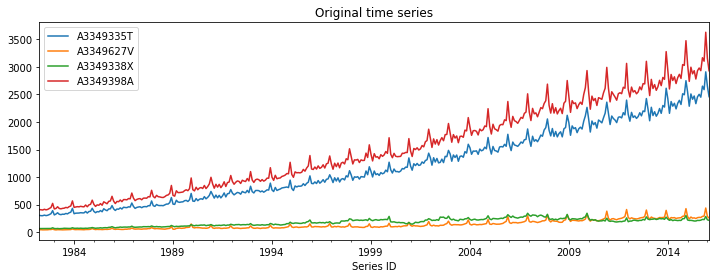

In [6]:
train_bound = pd.Timestamp('2016-02-01')
train = aus_retail[aus_retail.index <= train_bound].iloc[:, :4]
test = aus_retail[aus_retail.index > train_bound].iloc[:, :4]
train.plot(figsize=(12, 4))
plt.title('Original time series')
plt.show()

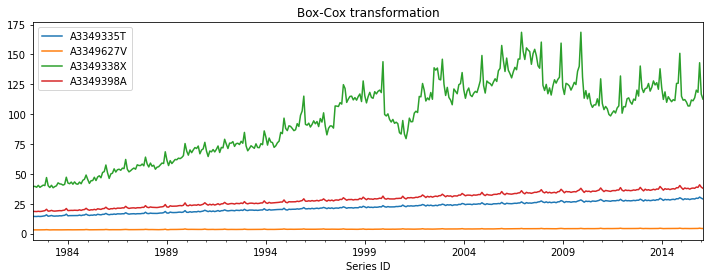

In [7]:
boxcox_model = BoxCox()
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
bc_train.plot(figsize=(12, 4))
plt.title('Box-Cox transformation')
plt.show()

In [8]:
def differencing(ts, periods):
    return ts.diff(periods=periods).dropna()

def integration(ts, periods, original_ts):
    ts_concat = pd.concat([original_ts.iloc[:periods], ts])
    ts_integration = []
    for i in range(periods):
        ts_integration.append(ts_concat.iloc[i::periods].cumsum(axis=0))
    return pd.concat(ts_integration).sort_index()

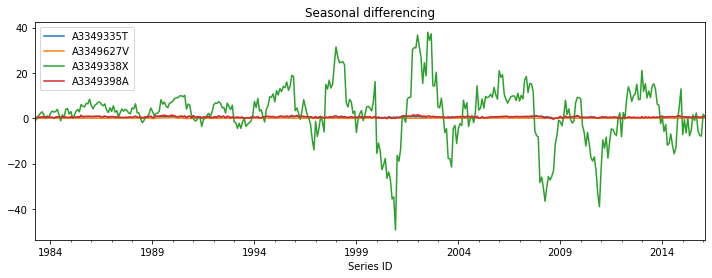

In [9]:
seasonal_lag = 12
t_train = differencing(bc_train, seasonal_lag)
t_train.plot(figsize=(12, 4))
plt.title('Seasonal differencing')
plt.show()

In [10]:
import requests
url = 'https://raw.githubusercontent.com/locuslab/TCN/master/TCN/tcn.py'
open('tcn.py', 'wb').write(requests.get(url).content);

In [18]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, RMSprop
from tcn import TemporalConvNet, TemporalBlock

from IPython.display import clear_output

In [19]:
device = 'cuda'

In [20]:
train_torch = []
for i in range(t_train.shape[0] - 60*2):
    train_torch.append(t_train.iloc[i:i+60*2].values.T)
train_torch = torch.Tensor(train_torch).to(device)
train_torch.shape

torch.Size([275, 4, 120])

In [21]:
class TCNGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_conv = TemporalBlock(
            n_inputs=16, n_outputs=4, kernel_size=2, 
            stride=1, dilation=1, padding=1, dropout=0.2)
        self.inp_conv = TemporalBlock(
            n_inputs=4, n_outputs=4, kernel_size=2, 
            stride=1, dilation=1, padding=1, dropout=0.2)
        self.tcn = TemporalConvNet(
            num_inputs=4, num_channels=[4, 4, 4, 4, 4], 
            kernel_size=2, dropout=0.2)
        self.out_conv = nn.Conv1d(
            in_channels=4, out_channels=4, 
            kernel_size=1, stride=1, padding=0)
    def forward(self, x, z):
        h = self.tcn(self.z_conv(z) + self.inp_conv(x))
        return self.out_conv(h)

In [32]:
class TCNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = TemporalConvNet(
            num_inputs=4, num_channels=[4, 4, 4, 4, 4], 
            kernel_size=2, dropout=0.2)
        self.dense = nn.Linear(120, 1)
    def forward(self, x):
        h = self.tcn(x)
        return self.dense(h)

In [33]:
#gen = nn.Sequential(
#    TemporalConvNet(
#        num_inputs=4+4, num_channels=[4, 4, 4, 4], 
#        kernel_size=2, dropout=0.2),
#    nn.Linear(60, 60)).to(device);

#disc = nn.Sequential(
#    TemporalConvNet(
#        num_inputs=4, num_channels=[4, 4, 4, 4], 
#        kernel_size=2, dropout=0.2),
#    nn.Linear(120, 1)).to(device);

In [34]:
gen = TCNGenerator().to(device)
disc = TCNDiscriminator().to(device)

In [35]:
gen_opt = Adam(gen.parameters(), lr=0.0001)
disc_opt = Adam(disc.parameters(), lr=0.0005)

In [36]:
logs = []

In [37]:
n_epochs = 10000
batch_size = 128
for e in range(n_epochs):
    
    idx = np.random.choice(np.arange(train_torch.shape[0]), size=batch_size)
    real_x = train_torch[idx]
    cond = real_x[..., :60]
    z = torch.randn(batch_size, 16, 60, device=device)
    fake_x = torch.cat([cond, gen(cond, z)], dim=2)

    term1 = F.binary_cross_entropy_with_logits(
        disc(real_x), torch.ones(batch_size, 4, 1, device=device))
    term2 = F.binary_cross_entropy_with_logits(
        disc(fake_x), torch.zeros(batch_size, 4, 1, device=device))
    disc_loss = (term1 + term2).mean()

    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()

    z = torch.randn(batch_size, 16, 60, device=device)
    fake_x = torch.cat([cond, gen(cond, z)], dim=2)

    gen_loss = F.binary_cross_entropy_with_logits(
        disc(fake_x), torch.ones(batch_size, 4, 1, device=device)).mean()

    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

    logs.append([disc_loss.item(), gen_loss.item()])
    assert not np.isnan(logs[-1]).max()

    if e % 10 == 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(logs[-500:])
        plt.title(f'Epoch {e+1}/{n_epochs}')
        plt.legend(['Discriminator loss', 'Generator loss'], loc='upper left')
        plt.subplot(2, 1, 2)
        plt.plot(real_x[0, 0].cpu().detach().numpy(), label='Real')
        plt.plot(fake_x[0, 0].cpu().detach().numpy(), label='Fake')
        plt.legend(loc='upper left')
        plt.show()
        clear_output(wait=True)

KeyboardInterrupt: ignored

In [38]:
torch.save(gen, 'gen.model')
torch.save(disc, 'disc.model')

In [56]:
with torch.no_grad():
    forecasts = []
    for _ in range(1000):
        z = torch.randn(batch_size, 16, 60, device=device)
        forecasts.append(gen(train_torch[-1:, :, 60:], z))
    forecasts = torch.cat(forecasts).cpu().numpy()
proba_forecast = np.quantile(forecasts, q=[0.025, 0.5, 0.975], axis=0)
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

In [59]:
point_forecast = pd.DataFrame(
    point_forecast.T, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast.T, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast.T, columns=test.columns, index=test.index)

In [60]:
pred = point_forecast.copy()
lower = lower_forecast.copy()
upper = upper_forecast.copy()

In [61]:
bc_pred = integration(point_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_lower = integration(lower_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_upper = integration(upper_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_pred.shape

(60, 4)

In [62]:
bc_lower[bc_lower < 0] = 0

In [63]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = inv_boxcox(bc_pred[col].values, lambds[col])
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])
pred.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,2635.173864,253.971753,214.019727,3122.271378
2016-04-01,2509.662321,254.858791,208.871178,2973.286571
2016-05-01,2566.142935,242.849211,201.873711,3027.361827
2016-06-01,2392.323668,260.961828,201.247106,2844.451682
2016-07-01,2545.620655,252.186120,212.705146,3022.271473


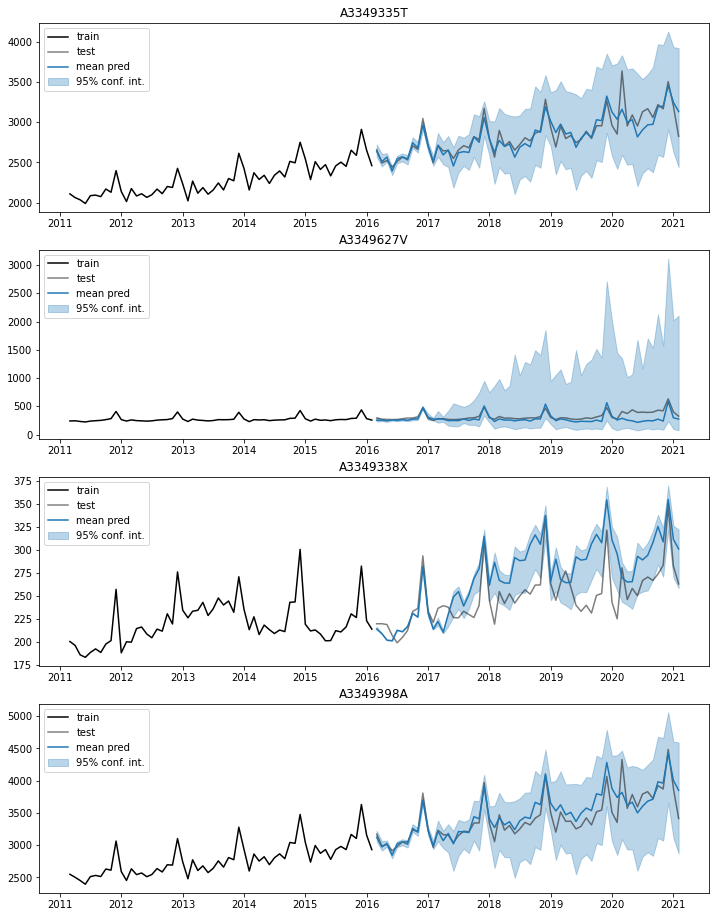

In [64]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)